In [94]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
import numpy as np
import scipy.cluster.hierarchy as sch

In [32]:
df = pd.read_csv("../../data/01-modified-data/New_students_adaptability.csv")

In [89]:
# Removing the label column for clustering
df_clustering = df.drop(['Adaptivity Level', 'Unnamed: 0'],axis=1)

# Standardizing the data 
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clustering)

In [34]:
# Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init= 10)
    kmeans.fit(df_clustering)
    wcss.append(kmeans.inertia_)

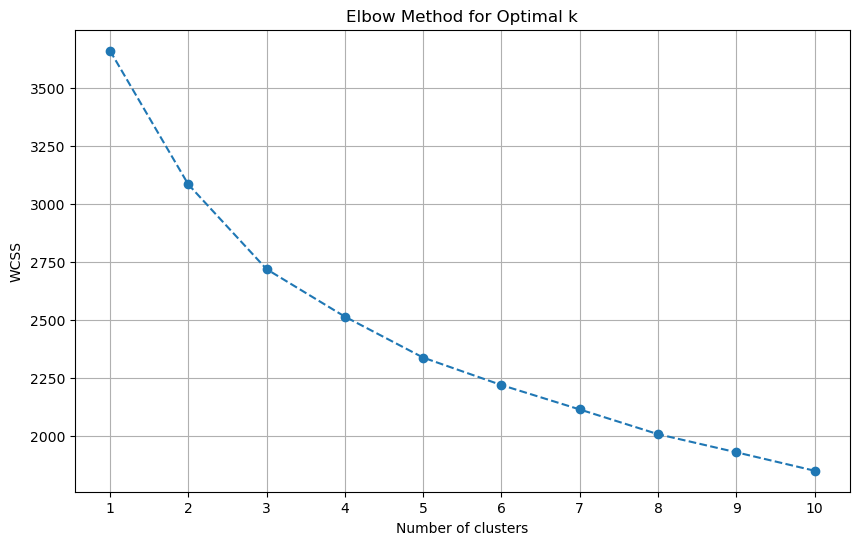

In [35]:
# Plotting the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

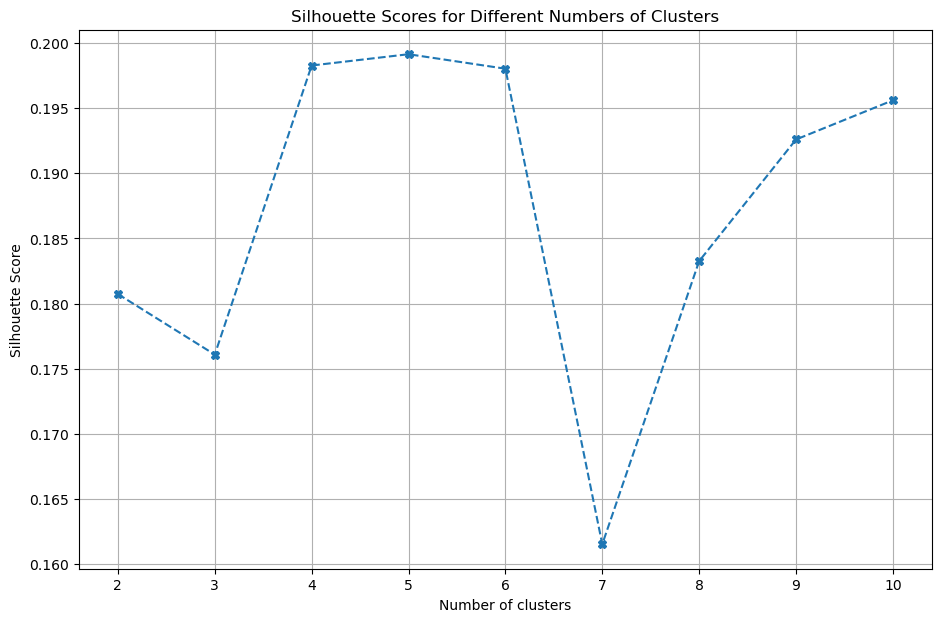

In [37]:
# Silhouette score method

silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, n_init= 10)
    kmeans.fit(df_clustering)
    score = silhouette_score(df_clustering, kmeans.labels_)
    silhouette_scores.append(score)

# Plotting the Silhouette Scores
plt.figure(figsize=(11, 7))
plt.plot(range(2, 11), silhouette_scores, marker='X', linestyle='--')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()

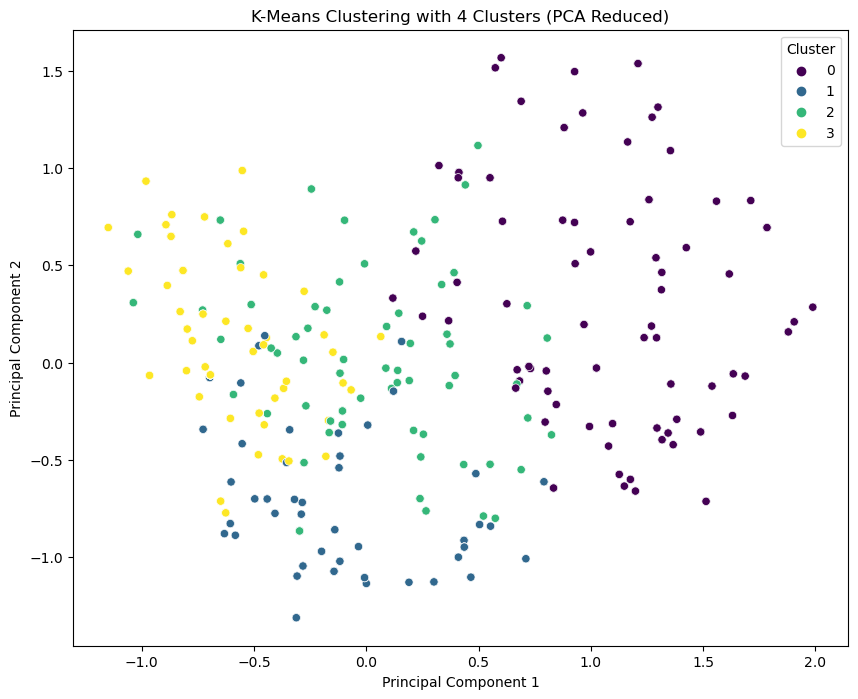

In [52]:
# Performing K-Means Clustering with k=4

from sklearn.decomposition import PCA


kmeans_optimal = KMeans(n_clusters=4, n_init= 10)
cluster_labels = kmeans_optimal.fit_predict(df_clustering)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_clustering)


pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = cluster_labels

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis')
plt.title('K-Means Clustering with 4 Clusters (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()



In [71]:

# Exploring different distance metrics for DBSCAN
distance_metrics = ['euclidean', 'manhattan', 'chebyshev']
eps_values = np.arange(0.1, 2.0, 0.1)
min_samples_values = range(2, 20)

results = []
for metric in distance_metrics:
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
            clusters = dbscan.fit_predict(df_scaled)

            # Only compute silhouette score if more than 1 cluster and less than n-1 noise points
            if len(np.unique(clusters)) > 1 and len(np.unique(clusters)) < len(df_scaled) - 1:
                silhouette_avg = silhouette_score(df_scaled, clusters)
                results.append((metric, eps, min_samples, silhouette_avg))

results_sorted = sorted(results, key=lambda x: x[3], reverse=True)

# Displaying the top 5 results
print(results_sorted[:5])


[('euclidean', 0.1, 2, 0.9891212061344831), ('euclidean', 0.2, 2, 0.9891212061344831), ('euclidean', 0.30000000000000004, 2, 0.9891212061344831), ('euclidean', 0.4, 2, 0.9891212061344831), ('euclidean', 0.5, 2, 0.9891212061344831)]


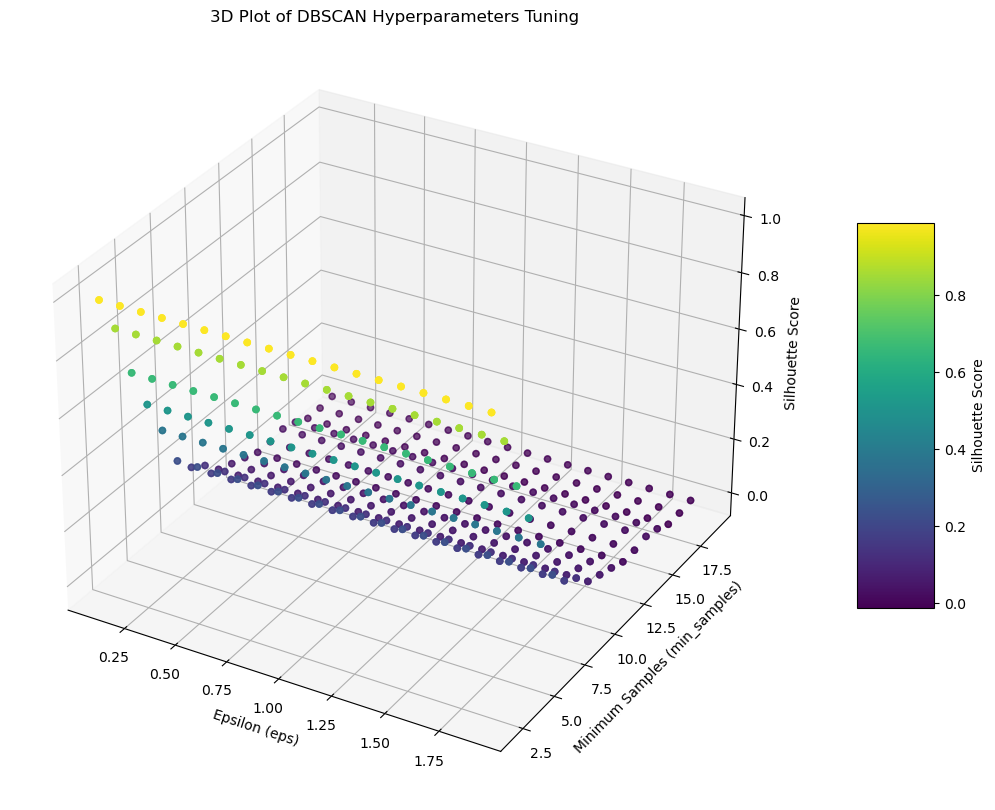

In [63]:
# 3D Visualization 

# Extract the eps, min_samples, and silhouette score for plotting
eps_list = [result[1] for result in results_sorted]
min_samples_list = [result[2] for result in results_sorted]
silhouette_scores = [result[3] for result in results_sorted]


fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')

scat = ax.scatter(eps_list, min_samples_list, silhouette_scores, c=silhouette_scores, cmap='viridis')

cbar = fig.colorbar(scat, shrink=0.5, aspect=5)
cbar.set_label('Silhouette Score')
ax.set_xlabel('Epsilon (eps)')
ax.set_ylabel('Minimum Samples (min_samples)')
ax.set_zlabel('Silhouette Score')
ax.set_title('3D Plot of DBSCAN Hyperparameters Tuning')

plt.show()



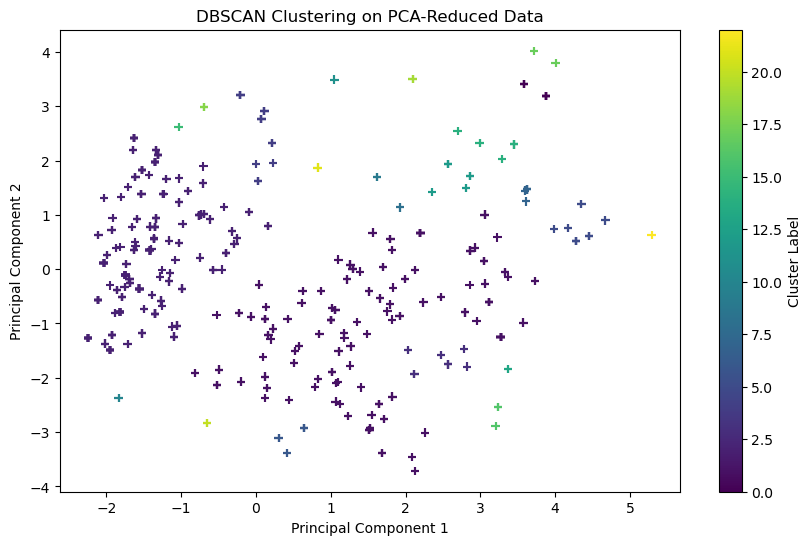

In [81]:
# DBSCAN with the optimal hyperparameters on the PCA-reduced data
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

dbscan = DBSCAN(eps=0.5, min_samples=2, metric='euclidean')
clusters_pca = dbscan.fit_predict(df_pca)


plt.figure(figsize=(10, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=clusters_pca, cmap='viridis', marker='+')
plt.title('DBSCAN Clustering on PCA-Reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()





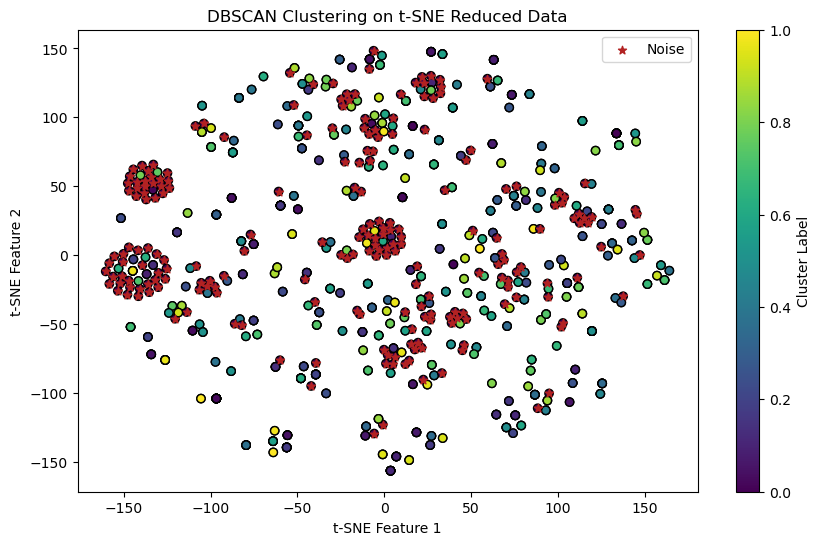

In [93]:
from sklearn.manifold import TSNE


# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=0)
df_tsne = tsne.fit_transform(df_scaled)


dbscan = DBSCAN(eps=0.5, min_samples=2, metric='euclidean')
clusters = dbscan.fit_predict(df_tsne)


plt.figure(figsize=(10, 6))
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='k')

noise = np.where(clusters == -1)[0]
plt.scatter(df_tsne[noise, 0], df_tsne[noise, 1], c='firebrick', marker='*', label='Noise')

plt.title('DBSCAN Clustering on t-SNE Reduced Data')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.colorbar(label='Cluster Label')
plt.legend()
plt.show()



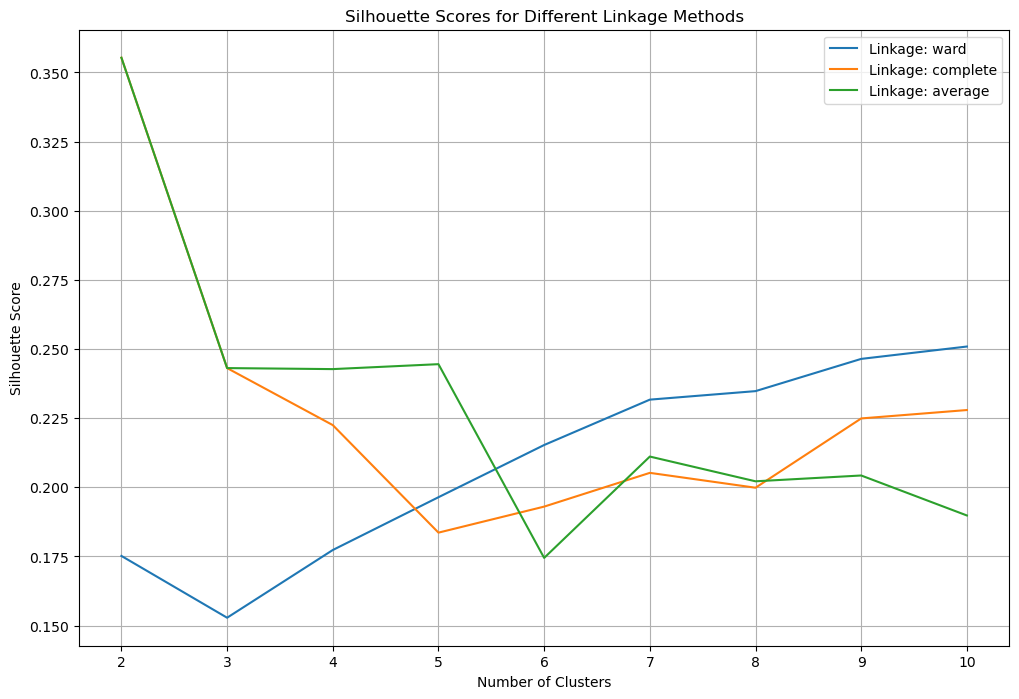

In [100]:

# Hierarchical Clustering
# Parameters for tuning
n_clusters_options = range(2, 11)  # Exploring number of clusters from 2 to 10
linkage_options = ['ward', 'complete', 'average']  # Different linkage criteria

silhouette_scores = np.zeros((len(n_clusters_options), len(linkage_options)))

for i, n_clusters in enumerate(n_clusters_options):
    for j, linkage in enumerate(linkage_options):
        clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        cluster_labels = clustering.fit_predict(df_scaled)
        score = silhouette_score(df_scaled, cluster_labels)
        silhouette_scores[i, j] = score

plt.figure(figsize=(12, 8))
for i, linkage in enumerate(linkage_options):
    plt.plot(n_clusters_options, silhouette_scores[:, i], label=f'Linkage: {linkage}')

plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Linkage Methods')
plt.legend()
plt.grid(True)
plt.show()


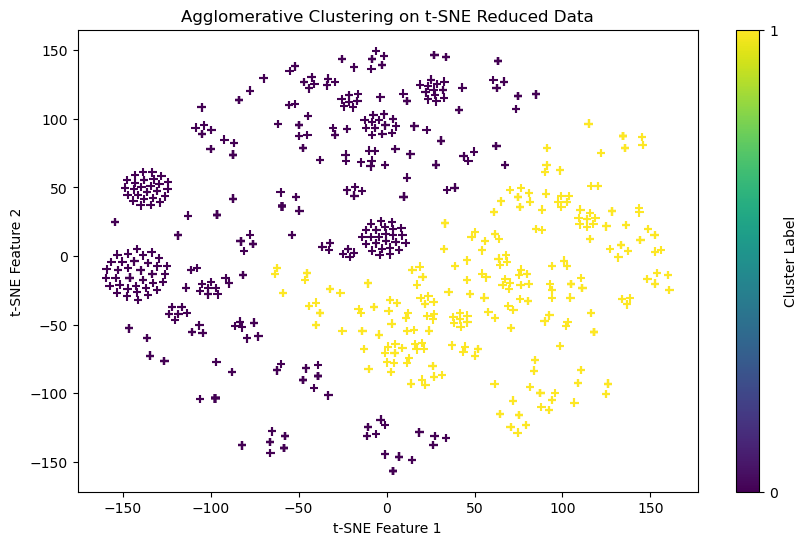

In [103]:
# Visualization of the final clusters for Hierarchical Clustering

# Optimal parameters from analysis
optimal_n_clusters = 2
optimal_linkage_method = 'ward'

agg_clust = AgglomerativeClustering(n_clusters=optimal_n_clusters, linkage=optimal_linkage_method)
final_clusters = agg_clust.fit_predict(df_scaled)


# t-SNE transformation
tsne = TSNE(n_components=2, random_state=42)
df_tsne = tsne.fit_transform(df_scaled)

# Plot the t-SNE 2D representation of the clusters
plt.figure(figsize=(10, 6))
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], c=final_clusters, cmap='viridis', marker='+')
plt.title('Agglomerative Clustering on t-SNE Reduced Data')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.colorbar(ticks=range(optimal_n_clusters), label='Cluster Label')
plt.show()


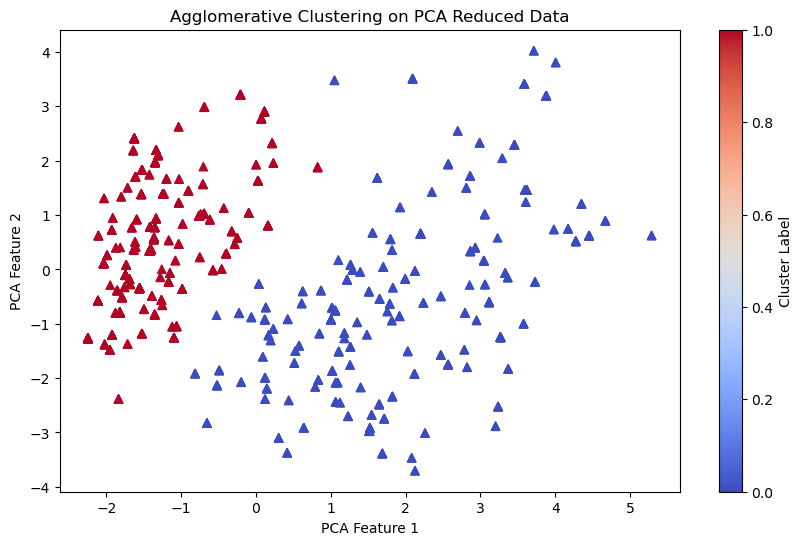

In [106]:

# Perform PCA dimensionality reduction
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Apply Agglomerative Clustering using the optimal hyperparameters
agg_clust = AgglomerativeClustering(n_clusters=2, linkage='ward')
final_clusters = agg_clust.fit_predict(df_pca)


plt.figure(figsize=(10, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=final_clusters, cmap='coolwarm', marker='^')
plt.title('Agglomerative Clustering on PCA Reduced Data')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()
